# Data pre-processing and pre-analysis
This will be a script for doing some of the initial pre-processing and analysis.

Script stages:

1) Initial stuff and functions for loading in the data and resizing etc.

2) Constructing the model

3) Initial test to make sure everything works

4) Parameter optimisation using SciKit + kerasclassifier

### Things to change
- Should load the data into memory and then give it to functions (maybe using an if not none), because at the moment everything gets reloaded each time and it is slowing it down

In [1]:
# Importing libraries
import os, cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.utils import shuffle
from random import seed

# Defining paths
train_path = '../../../Desktop/kaggle/cats_dogs/train/' # Locating of dog files
test_path = '../../../Desktop/kaggle/cats_dogs/test1/' # Location of cat files
pickle_path = '../../../Desktop/kaggle/cats_dogs/' # Location where saving pickles
checkpoint_path = '/checkpoints' # Location for model_checkpoints

# Defining constants
NUM_TRAIN = 1000
NUM_TEST = 200
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
CHANNELS = 3
SAMPLE_SIZE = 250 # How many samples we take for the experiments (note will take even of each)

Will treat the data by their file links - I think this is easier for the time being as it stops having to lug around huge images

In [2]:
# Get the image files
train_files = [train_path + file_name for file_name in os.listdir(train_path)]
test_files = [test_path + file_name for file_name in os.listdir(test_path)]

dog_files = [file_name for file_name in train_files if 'train/dog' in file_name]
cat_files = [file_name for file_name in train_files if 'train/cat' in file_name]

print(dog_files[0:5])
print(cat_files[0:5])
print('There are {} dog files'.format(len(dog_files)))
print('There are {} cat files'.format(len(cat_files)))

['../../../Desktop/kaggle/cats_dogs/train/dog.0.jpg', '../../../Desktop/kaggle/cats_dogs/train/dog.1.jpg', '../../../Desktop/kaggle/cats_dogs/train/dog.10.jpg', '../../../Desktop/kaggle/cats_dogs/train/dog.100.jpg', '../../../Desktop/kaggle/cats_dogs/train/dog.1000.jpg']
['../../../Desktop/kaggle/cats_dogs/train/cat.0.jpg', '../../../Desktop/kaggle/cats_dogs/train/cat.1.jpg', '../../../Desktop/kaggle/cats_dogs/train/cat.10.jpg', '../../../Desktop/kaggle/cats_dogs/train/cat.100.jpg', '../../../Desktop/kaggle/cats_dogs/train/cat.1000.jpg']
There are 12500 dog files
There are 12500 cat files


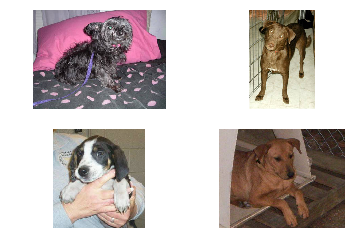

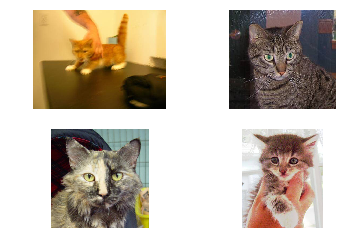

In [3]:
def panel_graph(image_files):
    images = [cv2.imread(image_file, cv2.IMREAD_COLOR) for image_file in image_files[0:4]]
    images = [image[:,:,::-1] for image in images] # default is BGR for cv2
    images = np.reshape(images, (2,2))
    _, ax = plt.subplots(2,2)
    for i in range(2):
        for j in range(2):
            ax[i,j].imshow(images[i, j])
            ax[i,j].axis('off')
    plt.show()

# Displaying some images
panel_graph(dog_files)
panel_graph(cat_files)

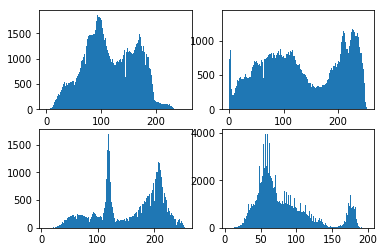

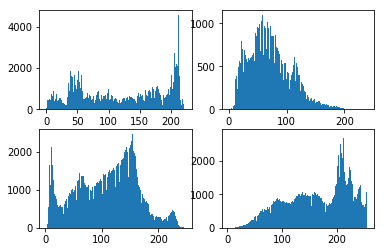

In [4]:
def panel_hist(image_files):
    images = [cv2.imread(image_file, cv2.IMREAD_COLOR).mean(axis=2).flatten() for image_file in image_files[0:4]]
    images = np.reshape(images, (2,2))
    _, ax = plt.subplots(2,2)
    for i in range(2):
        for j in range(2):
            ax[i,j].hist(images[i, j], 255)
            
    plt.show()

# Histograms of pixel values
panel_hist(dog_files)
panel_hist(cat_files)

Once looked at some of the raw data, will transform it and re-graph to see how stuff changes. Transformations to be made are

* Resize

* Histogram equalisation

* Mean image

In [5]:
# Data preparation
def data_read(image_path):
    '''
    Function to read in the data and do some of the basic transformations
    Note that it will take a single path and transform - everything is for one image
    '''
    # Load
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # Histogram
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])
    # Resize
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation = cv2.INTER_CUBIC)

def data_normalise(train, test = None):
    '''
    Function to get normalise - Note that re-defined because
    it was altering the original variable
    '''
    # Assuming we have a data frame of all pictures
    data_mean = train.mean(axis = 0)
    data_std = train.std(axis = 0)
    
    train_norm = train - data_mean
    train_norm /= data_std
    if test:
        test_norm = test - data_mean
        test_norm /= data_std
        return train, test, data_mean, data_std
    else:
        return train_norm, data_mean, data_std

def data_prep(image_files, read = False, write = False):
    '''
    Here we will try to combine all the files into a frame after processing them a bit
    '''
    num_files = len(image_files)
    file_name = pickle_path + 'all_image_data_' + str(num_files) + '.pickle'
    if read & os.path.exists(file_name):
        print('Loading dataset from file ' + file_name)
        with open(file_name, 'rb') as pickle_file:
            all_data = pickle.load(pickle_file)
        
    else:
        print('Loading images directly from file')
        all_data = np.ndarray((num_files, CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))

        for i, image_file in enumerate(image_files):
            # load in the processed image
            image = data_read(image_file)
            all_data[i] = image.T
            if i % 100 == 0:
                print('Loaded {} from {} files'.format(i, num_files))
        if write:
            with open(file_name, 'wb') as pickle_file:
                print('Writing dataset to file ' + file_name)
                pickle.dump(all_data, pickle_file)

    print('Final shape {}'.format(all_data.shape))
    return all_data
    

# Visualising the processed images
Now will just compare some of the images to see how it works. Not expecting them to necessarily "look" better, but to work better with a learning algorithm

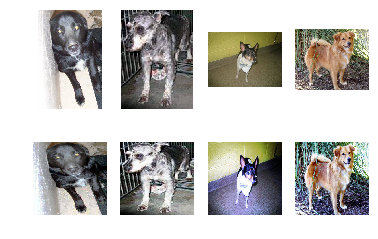

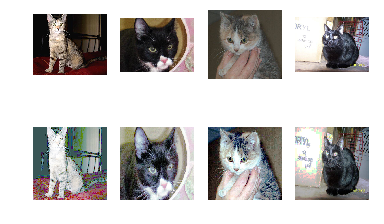

In [6]:
def image_compare(image_files, start = 0, end = 4):
    images_before = [cv2.imread(image_file, cv2.IMREAD_COLOR) for image_file in image_files[start:end]]
    images_before = [image[:,:,::-1] for image in images_before]
    images_after = [data_read(image_file)[:,:,::-1] for image_file in image_files[start:end]]    
    
    if start != end:
        size = end - start
    else:
        size = 1
        
    _, ax = plt.subplots(2, size)
    for i in range(size):
        ax[0,i].imshow(images_before[i])
        ax[1,i].imshow(images_after[i])
        ax[0,i].axis('off')
        ax[1,i].axis('off')
    plt.show()

# Displaying some images
image_compare(dog_files, start = 5, end = 9)
image_compare(cat_files, start = 5, end = 9)

Plotting Histograms as here should be more difference - from OpenCV

"Consider an image whose pixel values are confined to some specific range of values only. For eg, brighter image will have all pixels confined to high values. But a good image will have pixels from all regions of the image. So you need to stretch this histogram to either ends (as given in below image, from wikipedia) and that is what Histogram Equalization does (in simple words). This normally improves the contrast of the image."

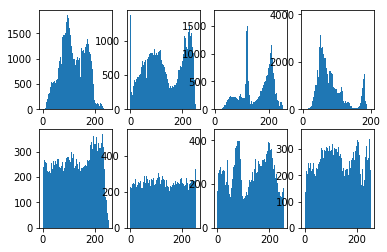

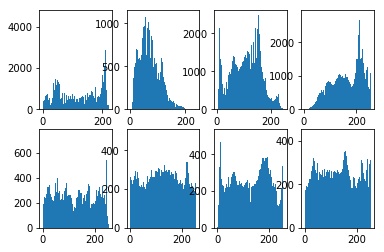

In [7]:
def hist_compare(image_files, start = 0, end = 4):
    images_before = [cv2.imread(image_file, cv2.IMREAD_COLOR).mean(axis=2).flatten() for image_file in image_files[start:end]]
    images_after = [data_read(image_file).mean(axis=2).flatten() for image_file in image_files[start:end]]    
    
    if start != end:
        size = end - start
    else:
        size = 1
        
    _, ax = plt.subplots(2, size)
    for i in range(size):
        ax[0,i].hist(images_before[i], 255)
        ax[1,i].hist(images_after[i], 255)
    plt.show()

# Displaying the histograms
hist_compare(dog_files)
hist_compare(cat_files)

Now will look at the whole data set and see how things look after normalisation - note that will only take the sample sized defined to investigate

Loading images directly from file
Loaded 0 from 500 files
Loaded 100 from 500 files
Loaded 200 from 500 files
Loaded 300 from 500 files
Loaded 400 from 500 files
Final shape (500, 3, 256, 256)


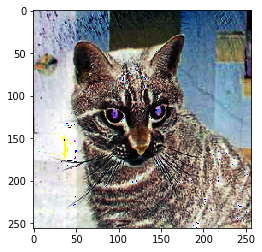

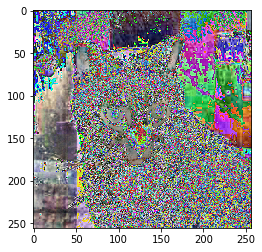

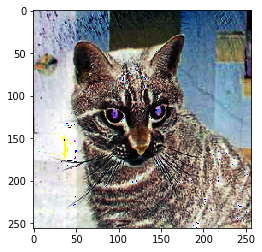

In [8]:
data_raw = data_prep(dog_files[0:SAMPLE_SIZE] + cat_files[0:SAMPLE_SIZE], read = False)
plt.imshow(data_raw[251].T)
plt.show()
data_norm, data_mean, data_std = data_normalise(data_raw)
plt.imshow(data_norm[251].T)
plt.show()
plt.imshow(data_raw[251].T)
plt.show()

(500, 3, 256, 256)
(3, 256, 256)


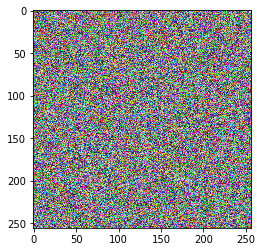

In [9]:
print(data_norm.shape)
print(data_mean.shape)

plt.imshow(data_mean.T)
plt.show()


# Constructing the model
After preprocessing stuff will start to actually construct the model to be used.

The first step will be to just construct a model to be used to test that everything is doing OK and for some sort of a baseline. Then later we will do some parameter optimisation and play around to see how things improve.

In [10]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# Wrapper to get the training set and labels
def get_data_labels(mode = 'Train'):
    if mode == 'Train':
        X = data_prep(dog_files[:NUM_TRAIN] + cat_files[:NUM_TRAIN])
        y = [1]*NUM_TRAIN + [0]*NUM_TRAIN
    elif mode == 'Test':
        X = data_prep(dog_files[NUM_TRAIN:NUM_TRAIN + NUM_TEST] + cat_files[NUM_TRAIN:NUM_TRAIN + NUM_TEST])
        y = [1]*NUM_TEST + [0]*NUM_TEST
    
    X, y = shuffle(X, y, random_state = 0)
    return X,y

# Defining model
def neural_network():
    input_shape = (CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT)
    model = Sequential()
    # conv layer 32 nodes, 2x2 window, 2 stride with relu activation
    model.add(Conv2D(32, 2, 2, input_shape = input_shape, activation = 'relu'))
    # Max pooling with 2,2 pool and 2,2 stride
    model.add(MaxPooling2D(pool_size = (2,2)))
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid')) # Note that as only one output - no different to softmax
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
    return model

# Callback class
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

def train_model(train, labels):
    model = neural_network()
    
    # Providing model with some validation data
    val_lim = int(0.8*2*NUM_TRAIN)
    train_dat = train[:val_lim,:,:,:]
    train_labels = labels[:val_lim]
    val_dat = train[val_lim:,:,:,:]
    val_labels = labels[val_lim:]
    
    print('Train data has dimensions {}'.format(train_dat.shape))
    print('Val data has dimensions {}'.format(val_dat.shape))
    
    # train, labels = get_data_labels() # I am going to remove this and load outside
    train_dat, data_mean, data_std = data_normalise(train_dat)
    val_dat -= data_mean
    val_dat /= data_std
    
    # Callbacks
    loss_history = LossHistory()
    early_stopping = EarlyStopping(patience=3, verbose=1)
    checkpoints = ModelCheckpoint(checkpoint_path, verbose=1, period = 5)
    
    model.fit(train_dat, train_labels, batch_size = 30, epochs = 30, validation_data = (val_dat, val_labels),
             shuffle = True, callbacks = [loss_history, early_stopping, checkpoints])
    return model, loss_history, data_mean, data_std # return just the model so that we don't have to give it test data and messy stuff

Using TensorFlow backend.


Once have all of the training details out of the way, will call everything and print the results

In [11]:
def get_test(test, labels, train_mean, train_std):
    #test_X, test_y = get_data_labels(mode = 'Test')
    test_norm = test - data_mean
    test_norm /= data_std
    
    return test_norm, labels

def run_training(train, labels):
    model, history, train_mean, train_std = train_model(train, labels)
    print('finished model training')

    # Graphing the loss
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.plot(history.losses, 'blue', label='Training Loss')
    plt.plot(history.val_losses, 'green', label='Validation Loss')
    plt.xticks(range(0,10)[0::2])
    plt.legend()
    plt.show()
    
    return model, history, train_mean, train_std

def test_model(test, labels, model, train_mean, train_std):
    test, labels = get_test(test, labels, train_mean, train_std)
    
    predictions = model.predict(test_X)
    
    print('Graphing distribution of predictions')
    plt.hist(predictions, 10)
    plt.show()
    
    prob_thresholds = np.arange(0, 1.1, 0.1)
    for thresh in prob_thresholds:
        y_hat = [1 if prediction > thresh else 0 for prediction in predictions]
        print('Accuracy at {} for a random test set is {}'.format(thresh, np.mean([y_h == y for y_h, y in zip(y_hat, test_y)])))
    
    return predictions

In [12]:
train_X, train_y = get_data_labels()
test_X, test_y = get_data_labels(mode = 'Test')

Loading images directly from file
Loaded 0 from 2000 files
Loaded 100 from 2000 files
Loaded 200 from 2000 files
Loaded 300 from 2000 files
Loaded 400 from 2000 files
Loaded 500 from 2000 files
Loaded 600 from 2000 files
Loaded 700 from 2000 files
Loaded 800 from 2000 files
Loaded 900 from 2000 files
Loaded 1000 from 2000 files
Loaded 1100 from 2000 files
Loaded 1200 from 2000 files
Loaded 1300 from 2000 files
Loaded 1400 from 2000 files
Loaded 1500 from 2000 files
Loaded 1600 from 2000 files
Loaded 1700 from 2000 files
Loaded 1800 from 2000 files
Loaded 1900 from 2000 files
Final shape (2000, 3, 256, 256)
Loading images directly from file
Loaded 0 from 400 files
Loaded 100 from 400 files
Loaded 200 from 400 files
Loaded 300 from 400 files
Final shape (400, 3, 256, 256)


In [ ]:
model, history, train_mean, train_std = run_training(train_X, train_y)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), input_shape=(3, 256, 2..., activation="relu")`


Train data has dimensions (1600, 3, 256, 256)
Val data has dimensions (400, 3, 256, 256)
Train on 1600 samples, validate on 400 samples
Epoch 1/30
1590/1600 [============================>.] - ETA: 0s - loss: 8.0000 - acc: 0.4881 

Graphing distribution of predictions


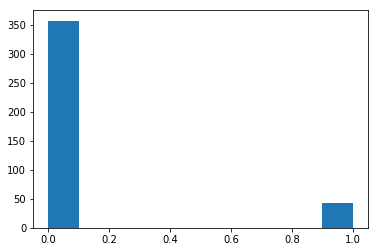

Accuracy at 0.0 for a random test set is 0.55
Accuracy at 0.1 for a random test set is 0.5275
Accuracy at 0.2 for a random test set is 0.5275
Accuracy at 0.30000000000000004 for a random test set is 0.5275
Accuracy at 0.4 for a random test set is 0.5275
Accuracy at 0.5 for a random test set is 0.5275
Accuracy at 0.6000000000000001 for a random test set is 0.5275
Accuracy at 0.7000000000000001 for a random test set is 0.5275
Accuracy at 0.8 for a random test set is 0.5275
Accuracy at 0.9 for a random test set is 0.5275
Accuracy at 1.0 for a random test set is 0.5


In [21]:
predictions = test_model(test_X, test_y, model, train_mean, train_std)